# Text classification with Huggingface transformers

Be sure to have Persistence set to an option including "Files" when swapping between CPU/GPU to use as little of the GPU quota as possible and still share objects between sessions.

Other useful materials:
-  https://karpathy.github.io/2019/04/25/recipe/

In [1]:
from pathlib import Path

In [2]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoModel
import torch
from torch import Tensor
from datasets import load_from_disk
from typing import List, Dict
from transformers import AutoTokenizer
from datasets import list_datasets

In [3]:
list_datasets()[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

Let's explore the `emotion` dataset

In [4]:
emotions = load_dataset('SetFit/emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/SetFit--emotion-ddb0f0516f8def09/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Note that `load_dataset` can also be used to load local datasets.

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

We can get dataset splits with itemgetter syntax

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [7]:
type(train_ds)

datasets.arrow_dataset.Dataset

This is an Arrow dataset

In [8]:
len(train_ds)

16000

In [9]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [10]:
train_ds.column_names

['text', 'label', 'label_text']

In [11]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

In [12]:
train_ds[:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3],
 'label_text': ['sadness', 'sadness', 'anger']}

We can also slice particular columns

In [13]:
train_ds['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

## From `Dataset`s to `DataFrame`s

Huggingface transformers provides an API to convert the *output* of a `Dataset` object to a Pandas `DataFrame`, whilst retaining the underlying data format of an Arrow table. This can be useful for e.g. visualisation.

In [14]:
emotions.set_format(type='pandas')
df = emotions['train'][:]

In [15]:
df

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Visualize the class distribution

<AxesSubplot:>

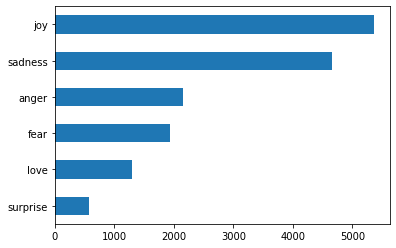

In [16]:
df['label_text'].value_counts(ascending=True).plot.barh()

To deal with imbalance, we can e.g.:
- Undersample over-represented classes
- Oversample under-represented classes
- Reweight the loss with the inverse category frequency

Be sure to only under/over-sample once you've performed a test/train split.

## Visualise token length

In [17]:
df['n_words'] = df['text'].str.split(' ').apply(len)

<AxesSubplot:title={'center':'n_words'}, xlabel='label_text'>

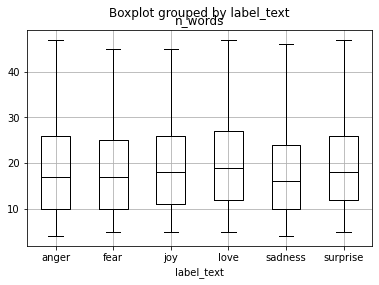

In [18]:
df.boxplot(column='n_words', by='label_text', showfliers=False, whis=(2.5, 97.5), color='black')

No substantial difference in the distribution of lengths

In [19]:
df['n_words'].describe()


count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: n_words, dtype: float64

The maximum number of words is well below DistilBERT's maximum context size.

When we're done with EDA, we can reset the output format.

In [20]:
emotions.reset_format()

## Tokenization

Character tokenization requires a model to learn how to form words from characters, putting a large burden on the language model. Word tokenization can result in very large vocabularies once you take declinations (?), conjugations, or misspellings into account. Subword tokenization is a more commonly-used middle-ground, and is typically learned from the corpus

We can load the tokenizer associated with a pre-trained model as follows:

In [21]:
model_ckpt = "distilbert-base-uncased"  # checkpoint name
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  # loads from a model checkpoint

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

We could've also used
```python
from transformers import DistilBertTokenizer
DistilBertTokenizer.from_pretrained(model_ckpt)
```

In [22]:
text = "Tokenizing text is (currently) a core task of NLP."

In [23]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1006, 2747, 1007, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

(We'll talk about `attention_mask` later)

In [24]:
len(encoded_text['input_ids']), len(text.split(' '))

(16, 9)

We can see how the tokenizer split the subwords up as follows:

In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 '(',
 'currently',
 ')',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

- The `[CLS]` and `[SEP]` tokens will vary from model to model, but their purpose is to indicate the start/end of a sequence
- The tokens are all lowercased
- "tokenizing" and "NLP" have been split into separate tokens, because they are not common words
- The `##` prefix means that the preceding characters are not whitespace and indicates the need to merge with the preceding token

In [26]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is ( currently ) a core task of nlp. [SEP]'

The tokenizer also contains metadata

In [27]:
tokenizer.vocab_size

30522

In [28]:
tokenizer.model_max_length

512

The model requires the following fields from the tokenizer:

In [29]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing an entire dataset

In [30]:
emotions["train"][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0],
 'label_text': ['sadness', 'sadness']}

In [31]:
def tokenize(batch: Dict[str, List]):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [32]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

We can see that the attention masks are zero-ing out the padding tokens.

We can now apply the `tokenize` function across all the splits of the corpus

In [33]:
# Using batched=True and batch_size=None will tokenize the entire dataset as a single batch, ensuring that 
# all sequences are padded to the same length
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [34]:
emotions_encoded["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask']

Models like DistilBERT are pretrained to predict masked words in a sequence of text. If we're interested in doing a classification task, we need to either perform:
- Feature extraction: Use the hidden states of the encoder block and train a classifier directly on those vectors
- Fine-tuning: Train the whole model end-to-end for the new task

## Transformers as feature extractors

We freeze the model and then can e.g. feed the features to a model like a gradient-boosting decision tree, or train a small neural classification layer.

We'll use another auto class from huggingface for this:

In [35]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Extracting the hidden states

In [36]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")  # return pytorch tensors
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [37]:
def extract_hidden_states(batch: Dict[str, Tensor]):
    # place model inputs on the device
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():  # don't compute the gradient -- we're just doing inference
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token (this is common practice)
    # Otherwise we'd have a vector for every token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [38]:
outputs = extract_hidden_states(inputs)
outputs['hidden_state'].shape

(1, 768)

To apply the above function on the whole dataset, we'll need to convert the `label`, `input_ids` and `attention_mask` to `torch` format

In [39]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [40]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [41]:
emotions_hidden['train'].column_names  # we now have a hidden state

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

In [42]:
# Must have Persistence to include files or this won't keep any files after restarting the session
emotions_hidden.save_to_disk('/kaggle/working/emotions_hidden')

In [3]:
# Must have Persistence to include files or this won't see any files 
emotions_hidden = load_from_disk('/kaggle/working/emotions_hidden')  

In [4]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

## Creating a feature matrix

In [5]:
import numpy as np

In [6]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape,X_valid.shape

((16000, 768), (2000, 768))